In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.distributions import Dirichlet, Bernoulli, Uniform
import pandas as pd
from tqdm import tqdm as tm

from src import Simulation as sim
from src import Dir_Reg
from src import Align
from src import visualize_latent_space as vls

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device("mps") if torch.backends.mps.is_available() else device

print(device)

cuda


Generate data sets that illustrate how the parameters of the model influence the behavior of the model. 
<br>
Settings:
<br>
Length of Time: 20 or 200
<br>
Embedding Dimemsion: 2
<br>
Number of Nodes: 1200
<br>
Parameters:  (1, 1, 5, 5), (1, 1, 2, 5), (1, 1, -2, 5), (1, 1, -5, 5)
<br>
Initial Distribution: Dir(1, 1, 1)


In [ ]:
torch.manual_seed(4)

T, n, alpha_0 = 20, 30, [[1,1,1], [1,1,1], [1,1,1]]

model_pos_2 = sim.ABC(time = T,
                    nodes = n,
                    beta = [1, 1, 2, 5],
                    alpha_0 = alpha_0)
model_pos_1 = sim.ABC(time = T*10,
                    nodes = n,
                    beta = [1, 1, 1 , 5],
                    alpha_0 = alpha_0)
model_neg_2 = sim.ABC(time = T*10,
                    nodes = n,
                    beta = [1, 1, -2, 5],
                    alpha_0 = alpha_0)
model_neg_5 = sim.ABC(time = T,
                    nodes = n,
                    beta = [1, 1, -5, 5],
                    alpha_0 = alpha_0)

In [ ]:
sim.ABC_Monte_Carlo.lat_pos(model_pos_2.synth_data["lat_pos"], 3).to_csv(r"simulated_data/time_vs_lat_pos/pos_2_sample.csv")
sim.ABC_Monte_Carlo.lat_pos(model_pos_1.synth_data["lat_pos"], 3).to_csv(r"simulated_data/time_vs_lat_pos/pos_1_sample.csv")
sim.ABC_Monte_Carlo.lat_pos(model_neg_2.synth_data["lat_pos"], 3).to_csv(r"simulated_data/time_vs_lat_pos/neg_2_sample.csv")
sim.ABC_Monte_Carlo.lat_pos(model_neg_5.synth_data["lat_pos"], 3).to_csv(r"simulated_data/time_vs_lat_pos/neg_5_sample.csv")

Below we generate the synthetic data set that shows how the latent position in ABCDPRGM evolves through time under different settings.

Let $\widehat{B} \in \mathbb{R}^{q \times p}$ be the MLE that corresponds to the design matrix $X \otimes I_p$, and $\tilde{\beta} = (C^T C)^{-1} C^T \widehat{B}$. Let $\widehat{\beta}$ be the MLE that corresponds to the design matrix $(X \otimes I_p)C$.

We first do Monte Carlo simulations to verify the asymptotic behavior of $\widehat{B}$ and $\tilde{\beta}$. 

In [6]:
""" no_oracle option is for the RGD stuff, which is still somewhat problematic. It shouldn't be turned on. """
N = 100
n_set = torch.arange(1200, 4500, 300)
beta = [1,1,-4, 5]
alpha_0 = [[10, 1, 1], [1, 10, 1], [1, 1, 10]]
OL, OA, NO = True, True, True
ntypes = OL + OA + NO

temp = sim.ABC_Monte_Carlo.consistency_T2(number_of_iterations = N, 
                                          nodes_set = n_set,
                                          beta = beta,
                                          alpha_0 = alpha_0,
                                          seeded = True,
                                          constrained = False,
                                          oracle_lat_pos = OL,
                                          oracle_align = OA,
                                          no_oracle = NO)

tensor(1200):   0%|          | 0/100 [00:00<?, ?it/s]

tensor(4200): 100%|██████████| 100/100 [03:09<00:00,  1.89s/it]


In [14]:
temp.MC_result.est.to_csv(r"simulated_data/emp_var_vs_obs_var/B_oracle.csv")
temp.MC_result.fish.to_csv(r"simulated_data/emp_var_vs_obs_var/B_fish.csv")

<Axes: xlabel='dim_0', ylabel='Count'>

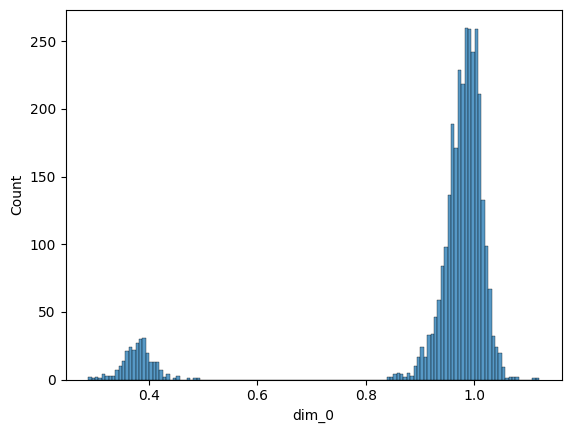

In [13]:
model = sim.ABC(time = 2,
            nodes = 3,
            beta = [1,1,-4, 5],
            alpha_0 = [[10, 1, 1], [1, 10, 1], [1, 1, 10]])
C = model.settings.C

res = torch.tensor(temp.MC_result.est["B_est"]).reshape(N*ntypes* len(n_set), 21).T


df = pd.DataFrame(torch.linalg.solve(C.T @ C, C.T @ res).T)


df.columns = ["dim_" + str(i) for i in range(4)]
sns.histplot(df["dim_0"])


In [15]:
temp.MC_result.fish

,nodes,method_1,method_2,method_3,fisher_info_1,fisher_info_2,fisher_info_3,fisher_info_4,fisher_info_5,fisher_info_6,...,fisher_info_432,fisher_info_433,fisher_info_434,fisher_info_435,fisher_info_436,fisher_info_437,fisher_info_438,fisher_info_439,fisher_info_440,fisher_info_441
0,1200,1,0,0,17359.078125,-5832.189941,-11503.158203,2214.593262,-842.637939,-1355.470703,...,18679.289062,-6895.951172,-17546.445312,24576.843750,-16177.106445,-6747.703613,23056.070312,-29692.042969,-30897.855469,60979.867188
1,1200,0,1,0,2863.864502,-904.092285,-1937.053711,492.186737,-171.981674,-302.831879,...,3797.916748,-1842.485107,-3763.496338,5734.482422,-3838.204102,-1746.015747,5711.305664,-6903.077637,-6723.995605,13999.058594
2,1200,0,0,1,2784.131592,-946.049133,-1816.522461,480.406189,-172.491730,-291.761475,...,4136.871582,-1719.161499,-3981.871582,5825.983398,-3667.595703,-1910.309326,5707.551270,-6558.694336,-7183.910156,14113.287109
3,1200,1,0,0,17573.398438,-5463.576172,-12086.650391,2301.829834,-822.040283,-1463.821533,...,19947.521484,-7168.658203,-17265.498047,24569.478516,-18621.007812,-6897.728516,25652.224609,-32533.789062,-30603.656250,63526.890625
4,1200,0,1,0,2695.570312,-812.027100,-1861.274902,423.337524,-143.056641,-262.914368,...,3826.600098,-1641.651123,-3730.419922,5501.844238,-3569.855957,-1646.491577,5343.936523,-6341.711426,-6560.361816,13270.474609
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3295,4200,0,1,0,24138.091797,-8042.823242,-16019.132812,3412.884277,-1260.661133,-2097.450684,...,30422.169922,-12731.381836,-29854.910156,43045.546875,-28332.105469,-12772.770508,41557.031250,-50997.550781,-52734.109375,105072.765625
3296,4200,0,0,1,24572.990234,-8274.405273,-16221.830078,3589.964355,-1264.232666,-2270.467773,...,29952.726562,-12688.089844,-28333.849609,41472.421875,-30012.791016,-12959.947266,43435.933594,-52775.140625,-51260.660156,105380.851562
3297,4200,1,0,0,59796.703125,-19228.357422,-40488.886719,7838.204102,-2847.827393,-4934.458008,...,64557.718750,-24363.380859,-54042.851562,78869.312500,-60380.789062,-23319.621094,84167.906250,-108129.976562,-99234.703125,208730.703125
3298,4200,0,1,0,23916.919922,-7455.551758,-16384.378906,3511.958252,-1251.118164,-2203.830322,...,29734.060547,-12915.422852,-27213.667969,40580.507812,-29322.763672,-12602.998047,42380.675781,-52342.765625,-49645.535156,103311.992188
